<a href="https://colab.research.google.com/github/seemonvakkala/Data-Analysis-task/blob/master/data_analysis_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load the data

In [1]:
#!/bin/bash
!curl -L -o ./online-retail-ecommerce-dataset.zip\
  https://www.kaggle.com/api/v1/datasets/download/ineubytes/online-retail-ecommerce-dataset
!unzip ./online-retail-ecommerce-dataset.zip
!rm ./online-retail-ecommerce-dataset.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 7371k  100 7371k    0     0  4968k      0  0:00:01  0:00:01 --:--:-- 22.0M
Archive:  ./online-retail-ecommerce-dataset.zip
  inflating: data.csv                


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [3]:
df = pd.read_csv('./data.csv', encoding='latin-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


## Clean the data

In [5]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df[df['UnitPrice'] > 0]
df['SalesValue'] = df['Quantity'] * df['UnitPrice']
df['Description'] = df['Description'].fillna('Unknown')
df['CustomerID'] = df['CustomerID'].fillna(-1).astype(int)

df = df.drop_duplicates()

df['Description'] = df['Description'].str.lower().str.strip()
df['Country'] = df['Country'].str.strip()

Q1_quantity = df['Quantity'].quantile(0.25)
Q3_quantity = df['Quantity'].quantile(0.75)
IQR_quantity = Q3_quantity - Q1_quantity

lower_bound_quantity = Q1_quantity - 1.5 * IQR_quantity
upper_bound_quantity = Q3_quantity + 1.5 * IQR_quantity

Q1_price = df['UnitPrice'].quantile(0.25)
Q3_price = df['UnitPrice'].quantile(0.75)
IQR_price = Q3_price - Q1_price

lower_bound_price = Q1_price - 1.5 * IQR_price
upper_bound_price = Q3_price + 1.5 * IQR_price

df = df[
    (df['Quantity'] >= lower_bound_quantity) & (df['Quantity'] <= upper_bound_quantity) &
    (df['UnitPrice'] >= lower_bound_price) & (df['UnitPrice'] <= upper_bound_price)
]

stock_counts = df['StockCode'].value_counts()
valid_stocks = stock_counts[stock_counts >= 50].index
df = df[df['StockCode'].isin(valid_stocks)]

<ipython-input-5-a2b4d033074c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SalesValue'] = df['Quantity'] * df['UnitPrice']
<ipython-input-5-a2b4d033074c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Description'] = df['Description'].fillna('Unknown')
<ipython-input-5-a2b4d033074c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

## Safety Stock Calculation
Safety Stock = z * std.dev * sqrt(LT)

is demand variability, and LT is lead time.

We will consider safety stock for next 7 days as lead time.

In [6]:
df['Day'] = df['InvoiceDate'].dt.date
daily_demand = df.groupby(['StockCode', 'Day'])['Quantity'].sum().reset_index()

demand_stats = daily_demand.groupby('StockCode')['Quantity'].agg(['mean', 'std']).reset_index()
demand_stats.rename(columns={'mean': 'MeanDemand', 'std': 'DemandStdDev'}, inplace=True)

Z = 1.65
lead_time = 7

demand_stats['SafetyStock'] = Z * demand_stats['DemandStdDev'] * np.sqrt(lead_time)

demand_stats.head()

,StockCode,MeanDemand,DemandStdDev,SafetyStock
0,10002,7.756098,9.164553,40.007760
1,10125,11.949153,10.988119,47.968518
2,10133,16.247525,14.859614,64.869490
3,10135,10.857143,12.069511,52.689327
4,11001,10.357143,8.893808,38.825829


## Reorder Point (ROP)
Formula:
ROP = Lead Time Demand+Safety Stock

In [7]:
demand_stats['LeadTimeDemand'] = demand_stats['MeanDemand'] * lead_time
demand_stats['ReorderPoint'] = demand_stats['LeadTimeDemand'] + demand_stats['SafetyStock']

print(demand_stats.head())

  StockCode  MeanDemand  DemandStdDev  SafetyStock  LeadTimeDemand  \
0     10002    7.756098      9.164553    40.007760       54.292683   
1     10125   11.949153     10.988119    47.968518       83.644068   
2     10133   16.247525     14.859614    64.869490      113.732673   
3     10135   10.857143     12.069511    52.689327       76.000000   
4     11001   10.357143      8.893808    38.825829       72.500000   

   ReorderPoint  
0     94.300443  
1    131.612586  
2    178.602163  
3    128.689327  
4    111.325829  


## Visualization

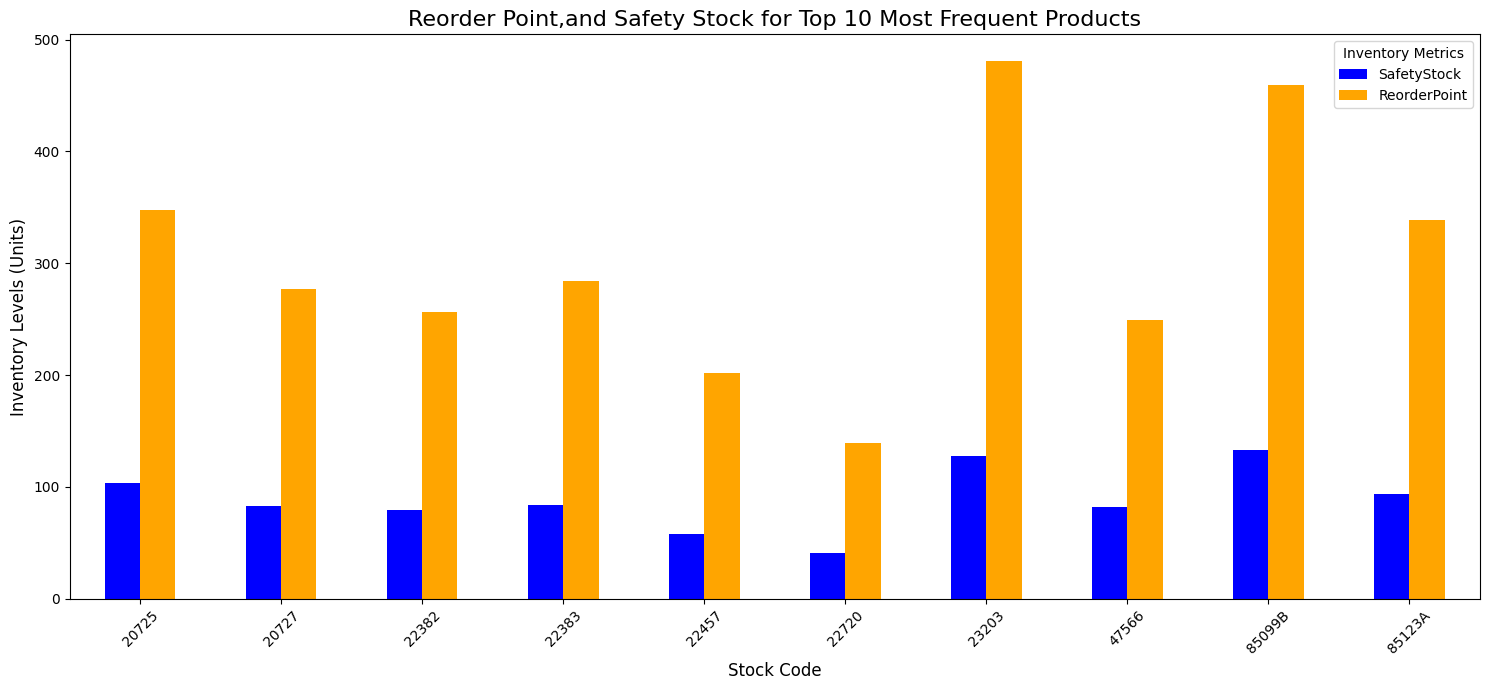

In [8]:
stock_counts = df['StockCode'].value_counts()
top_10_stocks = stock_counts.head(10).index
filtered_stats = demand_stats[demand_stats['StockCode'].isin(top_10_stocks)]
filtered_stats[['StockCode', 'SafetyStock', 'ReorderPoint']].set_index('StockCode').plot(
    kind='bar',
    figsize=(15, 7),
    color=['blue', 'orange', 'green']
)
plt.title("Reorder Point,and Safety Stock for Top 10 Most Frequent Products", fontsize=16)
plt.xlabel("Stock Code", fontsize=12)
plt.ylabel("Inventory Levels (Units)", fontsize=12)
plt.legend(title="Inventory Metrics", fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()